# Querying the RealEarth API

The GOES-18 satellite data which can be downloaded publicly from 1a is used in the University of Wisconsin-Madison Space Science and Engineering Center's Real Earth project. This may let us query the same data but manually put in the coordinates we want which will fix all headaches from downloading from NOAA directly.

Product link: https://realearth.ssec.wisc.edu/products/G18-ABI-CONUS-BAND02

API Documentation: https://realearth.ssec.wisc.edu/doc/api.php#keywords

Sample API query: https://realearth.ssec.wisc.edu/api/image?products=G18-ABI-CONUS-BAND02&time=20231022+214618&x=20&y=49&z=7

* Z=7 (1 image)
    * X=20 
    * Y=49
* Z=8 (4 images)
    * X=40, 41
    * Y=98, 99
* Z=9 (16 images)
    * X=80, 81, 82, 83
    * Y=196, 197, 198, 199

In [9]:
import numpy as np
import itertools

In [10]:
from PIL import Image
import requests
from io import BytesIO

In [11]:
url = 'https://realearth.ssec.wisc.edu/api/image?products=G18-ABI-CONUS-BAND02&time=20231022+214618&x=20&y=49&z=7'
response = requests.get(url)
img = Image.open(BytesIO(response.content))

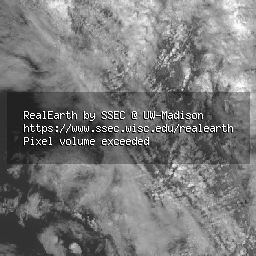

In [12]:
img

In [13]:
def get_fog_times(which='day'):
    time_url = f'https://realearth.ssec.wisc.edu/api/times?products=G18-ABI-CONUS-BAND02'
    response = requests.get(time_url)
    all_times = response.json()['G18-ABI-CONUS-BAND02']
    if which == 'all':
        times = all_times
    elif which == 'day':
        times = [time for time in all_times if (time.split('.')[1]>'150000') & (time.split('.')[1]<'235959')]
    else:
        print('Not valid, defaulting to all')
    return times

In [14]:
times = get_fog_times(which='day')
times[-1]

'20231023.235618'

In [15]:
len(times)

755

In [16]:
def get_fog_img_url(x, y, z, time):
    url = f'https://realearth.ssec.wisc.edu/api/image?products=G18-ABI-CONUS-BAND02&time={time}&x={x}&y={y}&z={z}'
    return url

In [17]:
def get_big_image(time):
    z = 8
    x_list = [40, 41]
    y_list = [98, 99]

    img_list = []
    for iter in list(itertools.product(x_list,y_list)):
        x = iter[0]
        y = iter[1]
        iter_url = get_fog_img_url(x, y, z, time)
        response = requests.get(iter_url)
        img = Image.open(BytesIO(response.content))
        img_list.append(img)
        
    blank_image = Image.new("RGB", (512, 512))
    blank_image.paste(img_list[0], (0,0))
    blank_image.paste(img_list[1], (0,256))
    blank_image.paste(img_list[2], (256,0))
    blank_image.paste(img_list[3], (256,256))
    return blank_image

In [18]:
%%time
big_img_list = []
for time in times[:10]:
    big_img = get_big_image(time)
    big_img_list.append(big_img)

CPU times: total: 6.44 s
Wall time: 3min 32s


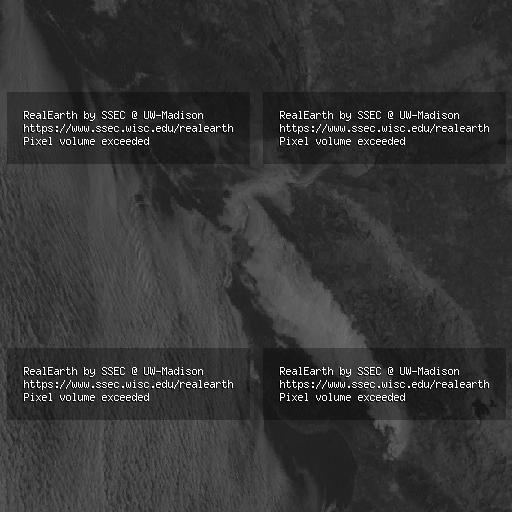

In [19]:
big_img

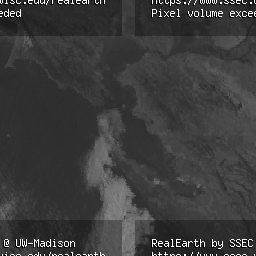

In [92]:
area = (128, 128, 384, 384)
cropped_img = big_img.crop(area)
cropped_img